In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')
!pip install transformers datasets scikit-learn accelerate

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

BASE_PATH = "/content/drive/MyDrive/assignment5"
DATA_PATH = os.path.join(BASE_PATH, "data")
SAVE_PATH = os.path.join(BASE_PATH, "saved_model_v5")

Mounted at /content/drive


In [ ]:
# 데이터 증강
INPUT_FILE = os.path.join(DATA_PATH, "train.csv")
OUTPUT_FILE = os.path.join(DATA_PATH, "train_aug.csv")

def aeda_augment(text, num_aug=1):
    punctuations = [".", ",", "!", "?", ";", ":"]
    if not isinstance(text, str) or len(text) < 2: return [str(text)] * num_aug
    words = text.split()
    augmented_texts = []

    for _ in range(num_aug):
        new_words = words[:]
        # 문장 길이의 15%만큼 부호 랜덤 삽입
        num_inserts = max(1, int(len(words) * 0.15))
        for _ in range(num_inserts):
            new_words.insert(random.randint(0, len(new_words) - 1), random.choice(punctuations))
        augmented_texts.append(" ".join(new_words))
    return augmented_texts

if os.path.exists(INPUT_FILE):
    train_df = pd.read_csv(INPUT_FILE)
    print(f"원본 데이터: {len(train_df)}개")

    aug_rows = []

    for idx, row in train_df.iterrows():
        aug_rows.append(row)

        is_weak = row['eval_category'] in ['장학', 'IEL']
        is_imp = row['label_importance'] in [1, 2]

        # 보통 데이터: 1개 추가 증강 (총 2배) -> 오버피팅 방지 및 학습량 확보
        # 취약 데이터: 3개 추가 증강 (총 4배) -> 불균형 해소
        if is_weak or is_imp:
            aug_count = 3
        else:
            aug_count = 1

        aug_titles = aeda_augment(row['title'], aug_count)
        aug_contents = aeda_augment(row['content'], aug_count)

        for i in range(aug_count):
            new_row = row.copy()
            new_row['title'] = aug_titles[i]
            new_row['content'] = aug_contents[i]
            aug_rows.append(new_row)

    aug_df = pd.DataFrame(aug_rows).sample(frac=1, random_state=42).reset_index(drop=True)
    aug_df.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')

    print(f"증강 완료! 저장 파일: {OUTPUT_FILE}")
    print(f"최종 데이터 개수: {len(aug_df)}개 (원본 대비 {len(aug_df)/len(train_df):.1f}배 증가)")
else:
    print("train.csv가 없습니다.")

원본 데이터: 1082개
증강 완료! 저장 파일: /content/drive/MyDrive/assignment5/data/train_aug.csv
최종 데이터 개수: 3364개 (원본 대비 3.1배 증가)


In [ ]:
train_df = pd.read_csv(os.path.join(DATA_PATH, "train_aug.csv"))
val_df = pd.read_csv(os.path.join(DATA_PATH, "val.csv"))

train_df['text'] = train_df['title'] + " " + train_df['content'].fillna("")
val_df['text'] = val_df['title'] + " " + val_df['content'].fillna("")

In [ ]:
class MultiHeadRoberta(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.roberta = AutoModel.from_pretrained(model_name)

        self.dropout = nn.Dropout(0.2)

        self.rel_classifier = nn.Linear(768, 2)
        self.imp_classifier = nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)

        if isinstance(outputs, tuple):
            last_hidden_state = outputs[0]
        else:
            last_hidden_state = outputs.last_hidden_state

        pooled_output = last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)

        logits_rel = self.rel_classifier(pooled_output)
        logits_imp = self.imp_classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            rel_loss = loss_fct(logits_rel, labels[:, 0])
            imp_loss = loss_fct(logits_imp, labels[:, 1])
            loss = rel_loss + imp_loss

        return {"loss": loss, "logits_rel": logits_rel, "logits_imp": logits_imp}

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-small")

def tokenize_and_split(examples):
    tokenized = tokenizer(
        examples["text"], truncation=True, max_length=512, stride=128,
        return_overflowing_tokens=True, padding="max_length"
    )
    new_labels = []
    for i, mapping in enumerate(tokenized['overflow_to_sample_mapping']):
        rel = examples['label_relevance'][mapping]
        imp = examples['label_importance'][mapping]
        new_labels.append([rel, imp])
    tokenized["labels"] = new_labels
    return tokenized

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

train_tokenized = train_ds.map(tokenize_and_split, batched=True, remove_columns=train_ds.column_names)
val_tokenized = val_ds.map(tokenize_and_split, batched=True, remove_columns=val_ds.column_names)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/971 [00:00<?, ?B/s]

Map:   0%|          | 0/3364 [00:00<?, ? examples/s]

Map:   0%|          | 0/135 [00:00<?, ? examples/s]

In [ ]:
import torch
import numpy as np
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score

imp_labels = train_df['label_importance'].tolist()
class_weights = compute_class_weight('balanced', classes=np.unique(imp_labels), y=imp_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")

# 정확도 계산
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    logits_rel = predictions[0]
    logits_imp = predictions[1]

    preds_rel = np.argmax(logits_rel, axis=1)
    preds_imp = np.argmax(logits_imp, axis=1)

    return {
        "acc_rel": accuracy_score(labels[:, 0], preds_rel),
        "acc_imp": accuracy_score(labels[:, 1], preds_imp)
    }

# Custom Trainer (Loss 가중치 최적화)
class MultiHeadTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], labels=labels)

        logits_rel = outputs["logits_rel"]
        logits_imp = outputs["logits_imp"]

        loss_fct_rel = torch.nn.CrossEntropyLoss()
        loss_fct_imp = torch.nn.CrossEntropyLoss(weight=class_weights)

        rel_loss = loss_fct_rel(logits_rel, labels[:, 0])
        imp_loss = loss_fct_imp(logits_imp, labels[:, 1])

        total_loss = rel_loss + (imp_loss * 1.5)

        return (total_loss, outputs) if return_outputs else total_loss

model = MultiHeadRoberta("klue/roberta-small")

args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,

    learning_rate=2e-5,
    weight_decay=0.05,

    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    remove_unused_columns=False,
    report_to="none"
)

trainer = MultiHeadTrainer(
    model=model,
    args=args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print(">>> 최종 학습 준비 완료")

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


>>> 최종 학습 준비 완료


In [ ]:
trainer.train()

if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
torch.save(model.state_dict(), os.path.join(SAVE_PATH, "pytorch_model.bin"))
tokenizer.save_pretrained(SAVE_PATH)
print(f"Model saved to: {SAVE_PATH}")

Epoch,Training Loss,Validation Loss,Acc Rel,Acc Imp
1,1.849600,1.494390,0.729064,0.802956
2,0.691100,1.170828,0.862069,0.862069
3,0.239500,2.205080,0.822660,0.832512
4,0.127200,2.575847,0.817734,0.857143


Model saved to: /content/drive/MyDrive/assignment5/saved_model_v5


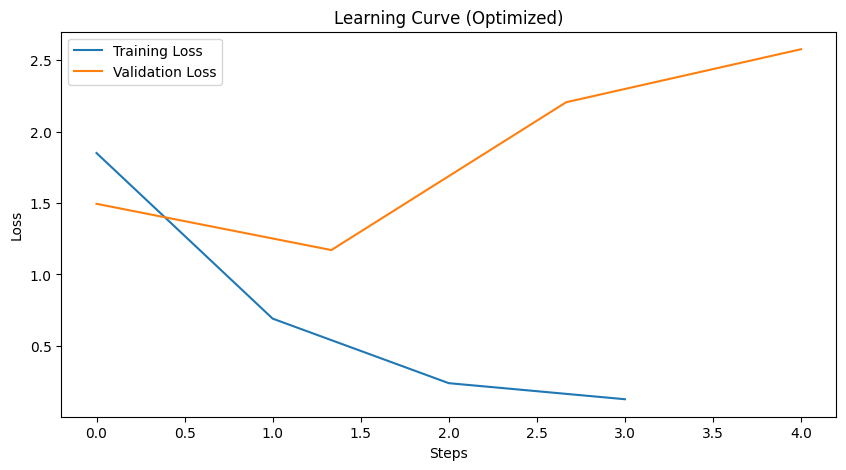

In [ ]:
history = trainer.state.log_history
train_loss = [x['loss'] for x in history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
if len(eval_loss) > 0:
    plt.plot(np.linspace(0, len(train_loss), len(eval_loss)), eval_loss, label='Validation Loss')
plt.title('Learning Curve (Optimized)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Validation 결과 저장
print(">>> Validation 데이터 예측 및 결과 저장 중...")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

def predict_row(text):
    inputs = tokenizer(
        text, return_tensors="pt", truncation=True, max_length=512,
        stride=128, return_overflowing_tokens=True, padding="max_length"
    )
    input_ids = inputs['input_ids'].to(device)
    mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, mask)
        l_rel = outputs["logits_rel"]
        l_imp = outputs["logits_imp"]

        final_rel = torch.argmax(torch.max(l_rel, dim=0)[0]).item()
        final_imp = torch.argmax(torch.max(l_imp, dim=0)[0]).item()

    return final_rel, final_imp

preds_rel = []
preds_imp = []

for t in val_df['text']:
    r, i = predict_row(t)
    preds_rel.append(r)
    preds_imp.append(i)

val_results = val_df.copy()
val_results['pred_rel'] = preds_rel
val_results['pred_imp'] = preds_imp

save_csv_path = os.path.join(BASE_PATH, "val_results_v5.csv")
val_results.to_csv(save_csv_path, index=False, encoding='utf-8-sig')
print(f"Validation 결과 저장 완료: {save_csv_path}")

>>> Validation 데이터 예측 및 결과 저장 중...
Validation 결과 저장 완료: /content/drive/MyDrive/assignment5/val_results_v5.csv
